# Automatic Differentiation for nonlinear operators

@Author: Francesco Picetti - picettifrancesco@gmail.com

In this notebook, we build a new kind of operator that leverages a new entry in the PyTorch ecosystem, [functorch](https://pytorch.org/functorch/stable/). Basically, it allows for the computation of the Jacobian-vector product given a function defined with PyTorch primitives.

In [1]:
import torch
import occamypy as o

o.torch.back_utils.set_seed_everywhere(0)

try:
    from functorch import jvp
except ModuleNotFoundError:
    raise ModuleNotFoundError("This submodule requires functorch to be installed. Do it with:\n\tpip install functorch")

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
class OperatorAD(o.Operator):

    def __init__(self, domain: o.VectorTorch, range: o.VectorTorch, fwd_fn, background: o.VectorTorch = None, name: str = None):
        """
        Generic operator whose forward is defined, and adjoint is computed with automatic differentiation
        
        Args:
            domain: operator domain vector
            range: operator range vector
            fwd_fn: torch-compatible forward function
            background: vector in which the Jacobian will be computed
            name: function name for print purpose
        """
        self.fwd_fn = fwd_fn
        
        # store the vector to be multiplied with the Jacobian
        self.domain_tensor = torch.ones_like(domain[:])
        # store the domain vector in which the function will be linearized
        self.background = background if background is not None else domain

        super(OperatorAD, self).__init__(domain=domain, range=range)
        self.name = "OperatorAD" if name is None else name
        
    def forward(self, add, model, data):
        self.checkDomainRange(model, data)
        
        if not add:
            data.zero()
        data[:] += self.fwd_fn(model[:])
        return
    
    def adjoint(self, add, model, data):
        self.checkDomainRange(model, data)

        grad = jvp(self.fwd_fn, (self.background[:],), (self.domain_tensor,))[1]
        
        if not add:
            model.zero()
        model[:] += grad * data[:]
        return
    
    def set_background(self, in_content: o.VectorTorch):
        """
        Set the background vector in which the Jacobian will be computed

        Args:
            in_content: background vector
        """
        self.background.copy(in_content)


## Case 1: linear function $f(x)=x$

In [3]:
x = o.VectorTorch(torch.tensor([1., 2., 3.]))
print("x =", x)

x = tensor([1., 2., 3.])


Forward function

In [4]:
f = lambda x: x

Analytical gradient

In [5]:
g = lambda x: 1.

Instantiate the operator

In [6]:
A = OperatorAD(domain=x, range=x, fwd_fn=f, name="x")
print("A is %s" % A.name)

A is x


Forward computation: $\mathbf{y}=f(\mathbf{x}) = \mathbf{A} \mathbf{x}$

In [7]:
y = A * x
assert torch.allclose(y[:], f(x[:]))
print("y = f(x) =", y)

y = f(x) = tensor([1., 2., 3.])


Adjoint computation: $\mathbf{z} = \frac{\partial f}{\partial \mathbf{x}}\Bigr|_{\mathbf{x}=\mathbf{x}_0}  \mathbf{y}$

1. set the linearization domain where the gradient is computed (default is the domain vector passed to the `__init__`)

In [8]:
A.set_background(x)
print("The gradient ∂f/∂x will be computed at x0 =", A.background)

The gradient ∂f/∂x will be computed at x0 = tensor([1., 2., 3.])


2. compute the gradient and multiply it with data

In [9]:
z = A.H * y
assert torch.allclose(z[:], g(A.background[:]) * y[:])
print("z = ∂f/∂x0 * y =", z)

z = ∂f/∂x0 * y = tensor([1., 2., 3.])


Let's use another linearization point $\mathbf{x}_0$

In [10]:
x0 = x.clone().rand()
A.set_background(x0)
print("The gradient ∂f/∂x0 will be computed on x0 =", A.background)

The gradient ∂f/∂x0 will be computed on x0 = tensor([-0.0280,  2.0072, -3.0796])


In [11]:
z = A.H * y
assert torch.allclose(z[:], g(A.background[:]) * y[:])
print("z = ∂f/∂x0 * y =", z)

z = ∂f/∂x0 * y = tensor([1., 2., 3.])


As $f(x)=x$ is linear, we can compute the dot product test for operator $\mathbf{A}$

In [12]:
A.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 2.765655517578125e-05 seconds
Applying adjoint operator add=False
 Runs in: 0.0003085136413574219 seconds
Dot products add=False: domain=3.146009e-01 range=3.146009e-01 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

Applying forward operator add=True
 Runs in: 2.5510787963867188e-05 seconds
Applying adjoint operator add=True
 Runs in: 0.00028204917907714844 seconds
Dot products add=True: domain=6.292018e-01 range=6.292018e-01 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

-------------------------------------------------


## Case 2: nonlinear function $f(x) = x \sin(x)$

In [13]:
x = o.VectorTorch(torch.tensor([1., 2., 3.]))
print("x =", x)

x = tensor([1., 2., 3.])


Forward function

In [14]:
f = lambda x: x * torch.sin(x)

Analytical gradient

In [15]:
g = lambda x: x * torch.cos(x) + torch.sin(x)

Instantiate the operator

In [16]:
A = OperatorAD(domain=x, range=x, fwd_fn=f, name="x sin(x)")
print("A is %s" % A.name)

A is x sin(x)


Forward computation: $\mathbf{y}=f(\mathbf{x}) = \mathbf{A} \cdot \mathbf{x}$

In [17]:
 y = A * x
assert torch.allclose(y[:], f(x[:]))
print("y = f(x) =", y)

y = f(x) = tensor([0.8415, 1.8186, 0.4234])


Adjoint computation: $\mathbf{z} = \frac{\partial f}{\partial \mathbf{x}}\Bigr|_{\mathbf{x}=\mathbf{x}_0} \cdot \mathbf{y}$



In [18]:
print("The gradient ∂f/∂x0 will be computed on x0 =", A.background)

The gradient ∂f/∂x0 will be computed on x0 = tensor([1., 2., 3.])


In [19]:
z = A.H * y
assert torch.allclose(z[:], g(A.background[:]) * y[:])
print("z = ∂f1/∂x0 * y =", z)

z = ∂f1/∂x0 * y = tensor([ 1.1627,  0.1400, -1.1976])


Let's use another linearization point $\mathbf{x}_0$

In [20]:
x0 = x.clone().rand()
A.set_background(x0)
print("The gradient ∂f/∂x0 will be computed on x0 =", A.background)

The gradient ∂f/∂x0 will be computed on x0 = tensor([ 0.9901, -1.1308, -0.7355])


In [21]:
z = A.H * y
assert torch.allclose(z[:], g(A.background[:]) * y[:])
print("z = ∂f/∂x0 * y =", z)

z = ∂f/∂x0 * y = tensor([ 1.1606, -2.5213, -0.5149])


Finally, we can wrap $\mathbf{A}$ into a `NonlinearOperator` and compute the linearization test

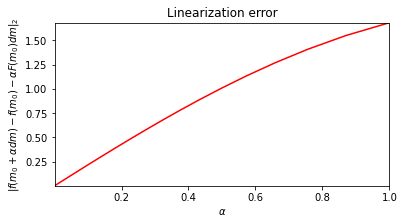

In [22]:
B = o.NonlinearOperator(A)
_, _ = B.linTest(x, plot=True)